<a href="https://colab.research.google.com/github/Giffy/fast.ai/blob/master/Machine%20Learning/lesson3_randomforest_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [16]:
!pip install fastai==0.7.0 > null
!wget https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/train.tar.gz
!tar xvf train.tar.gz
!wget https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/df_raw.tar.gz
!tar xvf df_raw.tar.gz

--2019-02-09 13:32:26--  https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9126495 (8.7M) [application/octet-stream]
Saving to: ‘train.tar.gz.2’

train.tar.gz.2      100%[===================>]   8.70M  --.-KB/s    in 0.09s   

2019-02-09 13:32:27 (97.3 MB/s) - ‘train.tar.gz.2’ saved [9126495/9126495]

data/bulldozers/Train.csv
data/bulldozers/training_dataset
data/
data/bulldozers/
--2019-02-09 13:32:30--  https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/df_raw.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|1

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [0]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [0]:
PATH = "/content/data/bulldozers/"                        # changed data path

In [0]:
import feather                                            # Import feather library
df_raw=feather.read_dataframe('tmp/bulldozers-raw')       # replaced:  df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [14]:
df_raw.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [0]:
set_rf_samples(50000)

In [15]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2061698159417829, 0.2491165859693108, 0.9111648188037567, 0.8891710392376584, 0.8941017469848419]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [18]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.61 s, sys: 75 ms, total: 1.69 s
Wall time: 1.69 s


(9.22441253615667, 0.30255157153083234)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [19]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 90.9 ms, sys: 187 ms, total: 277 ms
Wall time: 1.38 s


(9.22441253615667, 0.30255157153083234)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

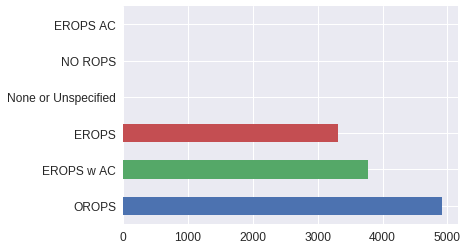

In [20]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [21]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.835687,0.271324
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.577369,0.265286
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.688425,0.220418


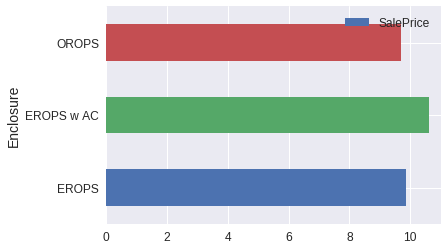

In [22]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

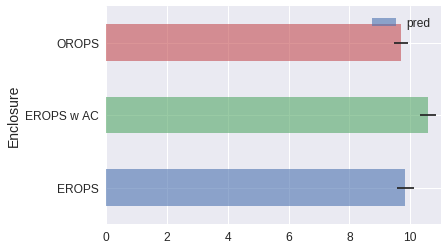

In [23]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

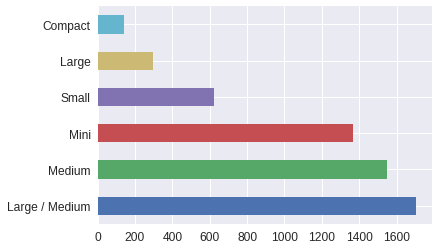

In [24]:
raw_valid.ProductSize.value_counts().plot.barh();

In [25]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.875564,0.346340
Large,10.470589,10.388510,0.366932
Large / Medium,10.691871,10.647947,0.298999
Medium,10.681511,10.624382,0.282171
Mini,9.535147,9.556070,0.245070
Small,10.324448,10.311493,0.311933


In [26]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.035321
Compact           0.035070
Small             0.030251
Large / Medium    0.028080
Medium            0.026559
Mini              0.025645
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [27]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.172691
37,Coupler_System,0.109614
13,ProductSize,0.098260
14,fiProductClassDesc,0.084602
2,ModelID,0.059308
63,saleElapsed,0.051426
38,Grouser_Tracks,0.046789
10,fiSecondaryDesc,0.041741
19,Enclosure,0.040817
39,Hydraulics_Flow,0.039282


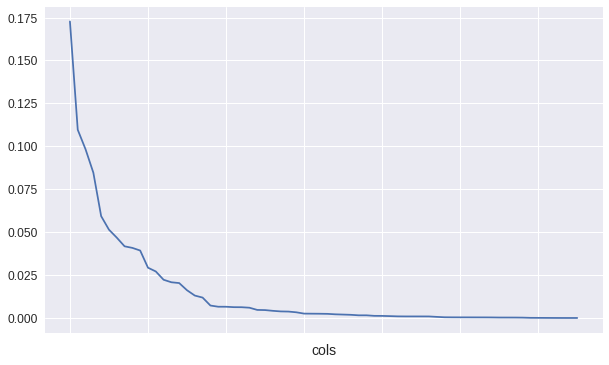

In [28]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

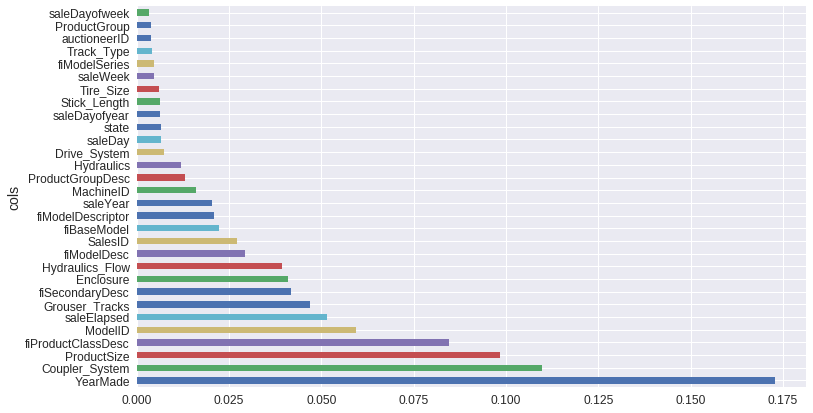

In [30]:
plot_fi(fi[:30]);

In [31]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [33]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20685054258682464, 0.2457327257290737, 0.9105772225266033, 0.892161467317764, 0.894102065513606]


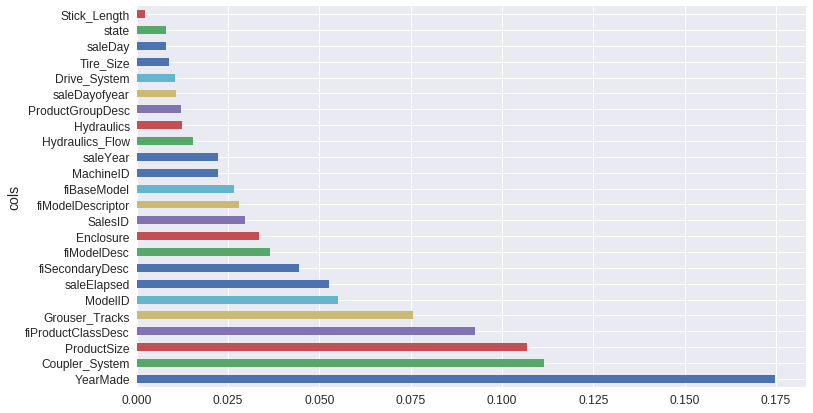

In [34]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [35]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2069393130166332, 0.2536105264082023, 0.9105004540384077, 0.8851363731892468, 0.8928884672392271]


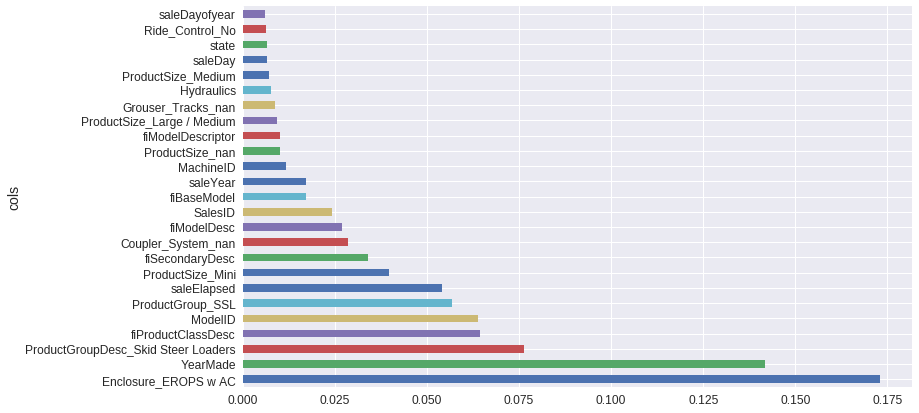

In [36]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [0]:
from scipy.cluster import hierarchy as hc

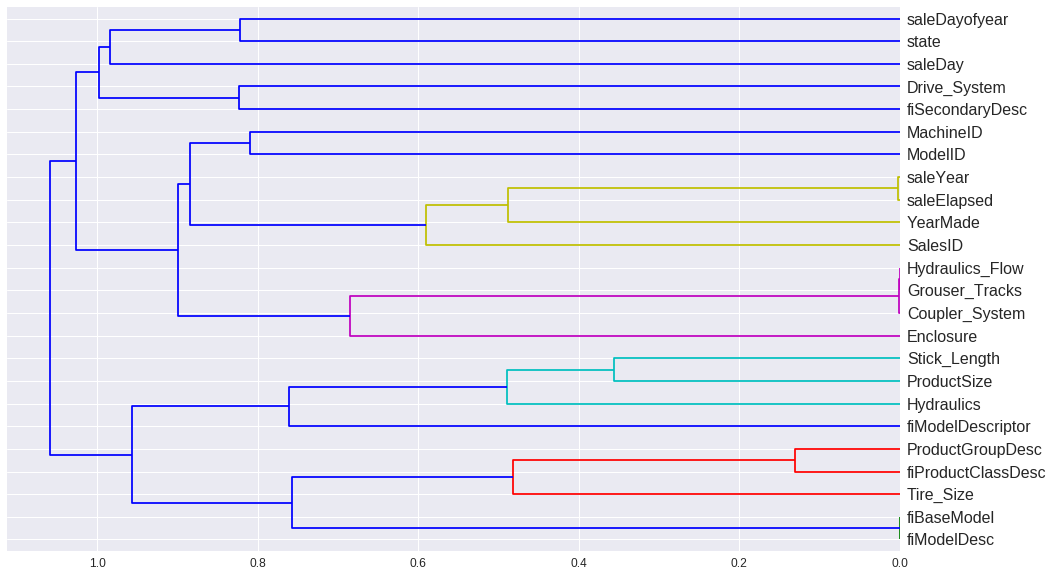

In [39]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [41]:
get_oob(df_keep)

0.8896172990075321

Now we try removing each variable one at a time.

In [42]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8894403029604603
saleElapsed 0.8865991454624786
fiModelDesc 0.8890863459453636
fiBaseModel 0.88936379933099
Grouser_Tracks 0.8894188828799269
Coupler_System 0.8895337842707185


It looks like we can try one from each group for removal. Let's see what that does.

In [43]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8885375194540678

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [0]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [0]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [0]:
reset_rf_samples()

In [48]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12563530348056906, 0.22646434921933062, 0.9670118308781388, 0.9084100838876152, 0.9087675905391399]


# Partial dependence

In [52]:
!pip install pdpbox
from pdpbox import pdp
from plotnine import *

    100% |████████████████████████████████| 57.7MB 417kB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

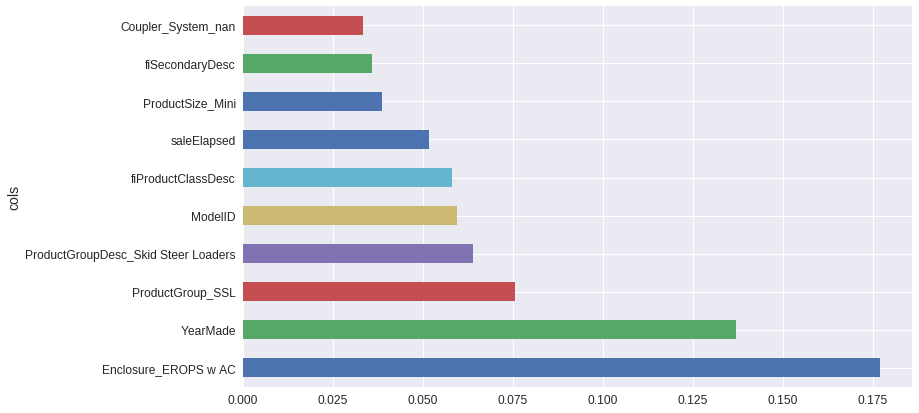

In [55]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


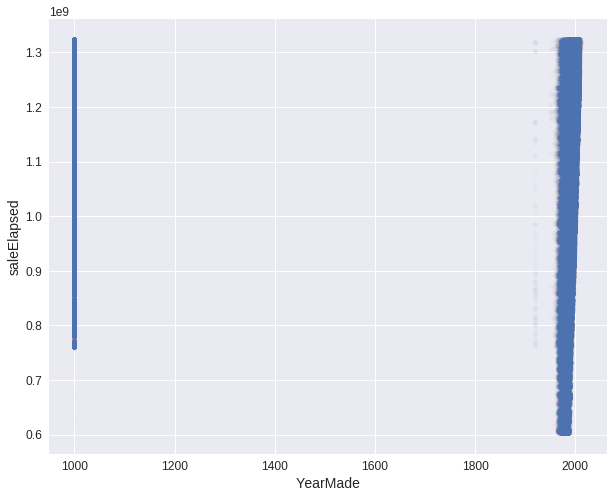

In [56]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [0]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

    100% |████████████████████████████████| 9.2MB 3.9MB/s 


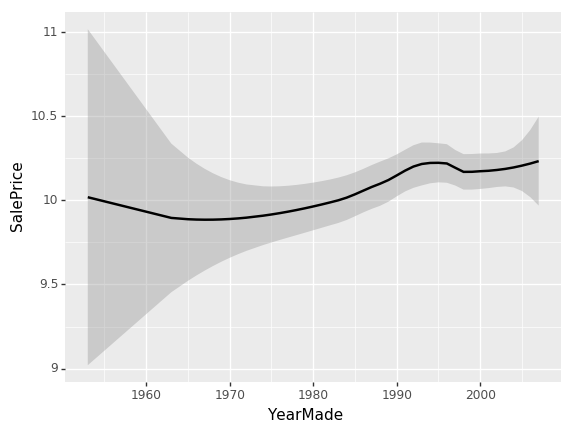

<ggplot: (8755717748530)>

In [63]:
!pip install scikit-misc
import skmisc
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [0]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [0]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f698c7720b8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f698c7b8ac8>})

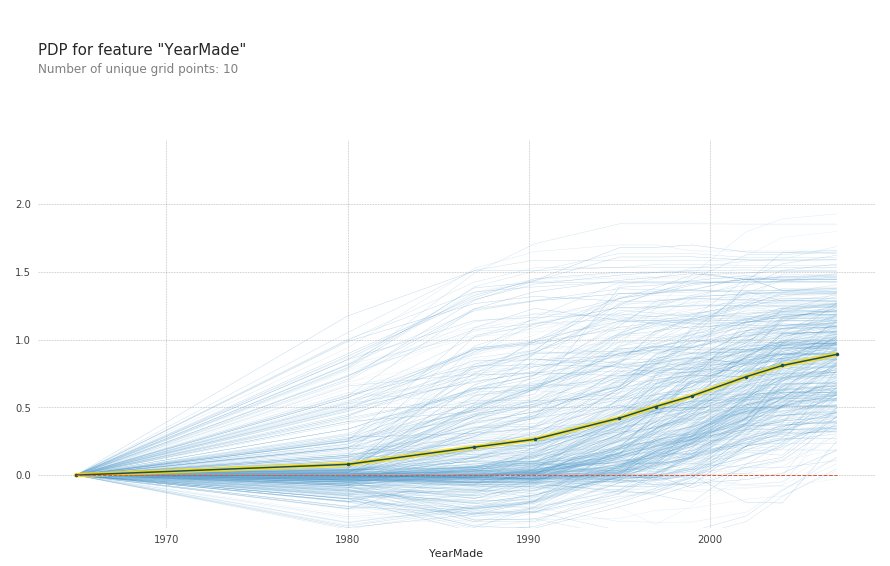

In [66]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f698c273d68>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f698c3b09b0>})

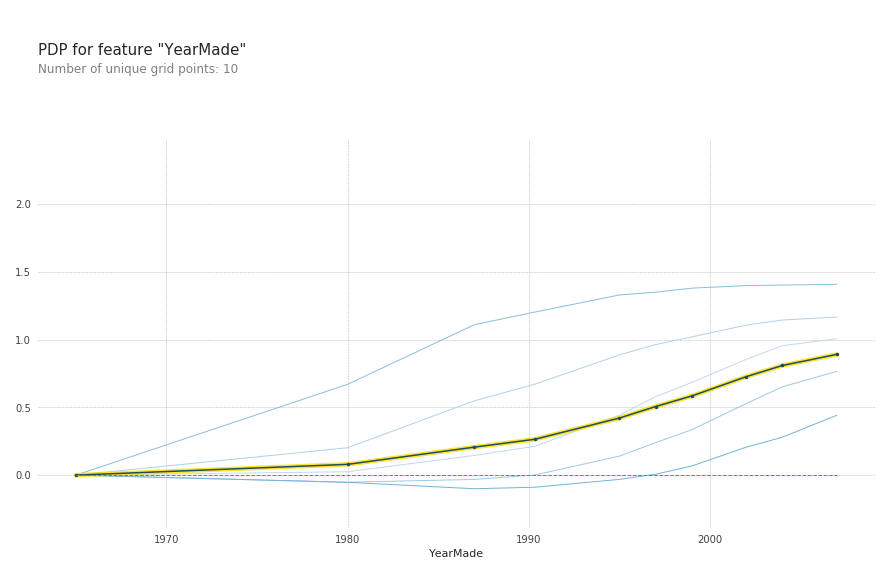

In [67]:
plot_pdp('YearMade', clusters=5)

TypeError: ignored

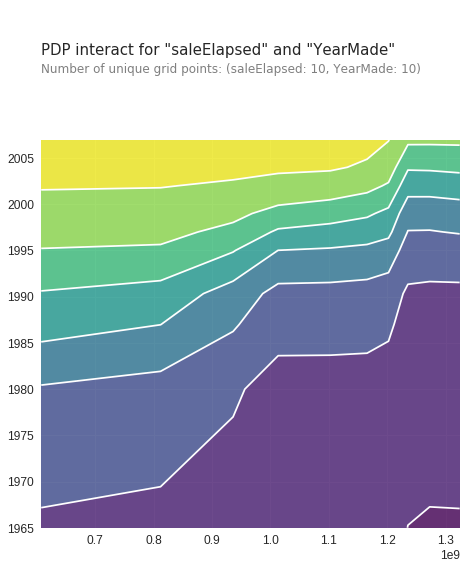

In [68]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

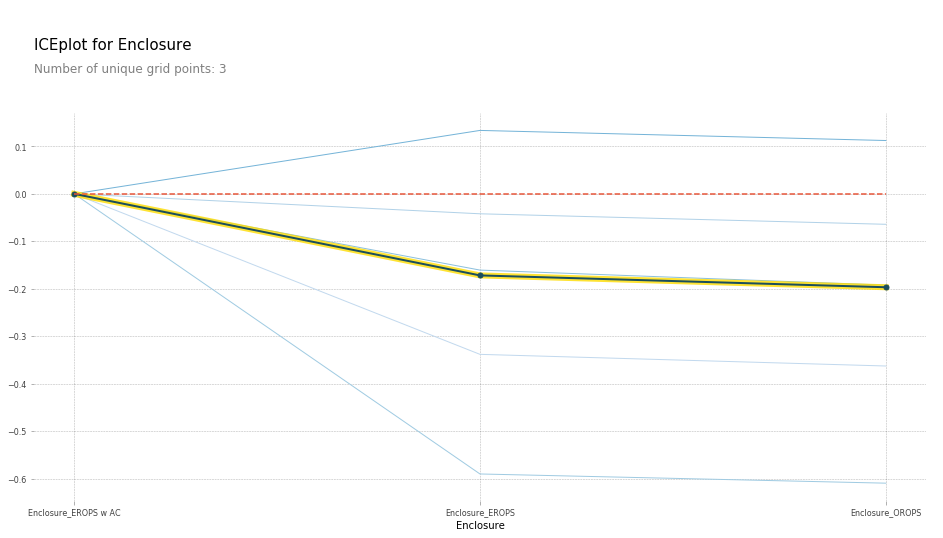

In [0]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [0]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

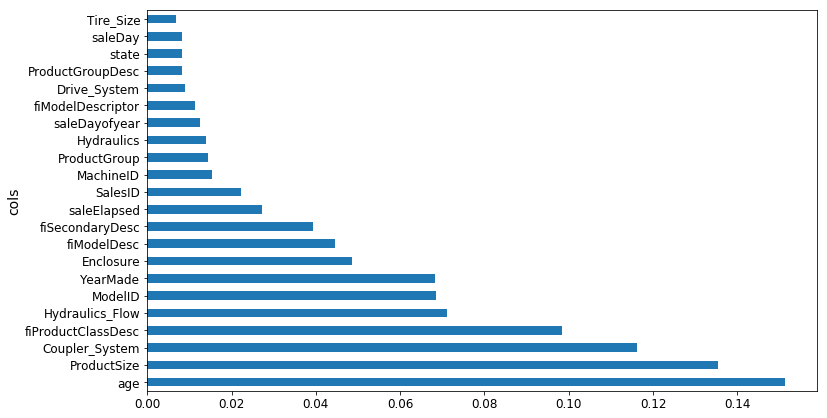

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [0]:
from treeinterpreter import treeinterpreter as ti

In [0]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [0]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 3, 3232, 1111, 0, 63, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9, 37,
        16, 3, 259, False, False, False, False, False, False, 7912, False, False]], dtype=object)

In [0]:
prediction, bias, contributions = ti.predict(m, row)

In [0]:
prediction[0], bias[0]

(9.1909688098736275, 10.10606580677884)

In [0]:
idxs = np.argsort(contributions[0])

In [0]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54680742853695008),
 ('age', 11, -0.12507089451852943),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
 ('fiModelDesc', 'KX1212', -0.065155113754146801),
 ('fiSecondaryDesc', nan, -0.055237427792181749),
 ('Enclosure', 'EROPS', -0.050467175593900217),
 ('fiModelDescriptor', nan, -0.042354676935508852),
 ('saleElapsed', 7912, -0.019642242073500914),
 ('saleDay', 16, -0.012812993479652724),
 ('Tire_Size', nan, -0.0029687660942271598),
 ('SalesID', 4364751, -0.0010443985823001434),
 ('saleDayofyear', 259, -0.00086540581130196688),
 ('Drive_System', nan, 0.0015385818526195915),
 ('Hydraulics', 'Standard', 0.0022411701338458821),
 ('state', 'Ohio', 0.0037587658190299409),
 ('ProductGroupDesc', 'Track Excavators', 0.0067688906745931197),
 ('ProductGroup', 'TEX', 0.014654732626326661),
 ('MachineID', 2300944, 0.015578052196894499),
 ('Hydraulics_Flow', nan, 0.028973749866174004),
 ('ModelID', 665, 0.0383074

In [0]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [0]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [0]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [0]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [0]:
x.drop(feats, axis=1, inplace=True)

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [0]:
set_rf_samples(50000)

In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [0]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [0]:
reset_rf_samples()

In [0]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


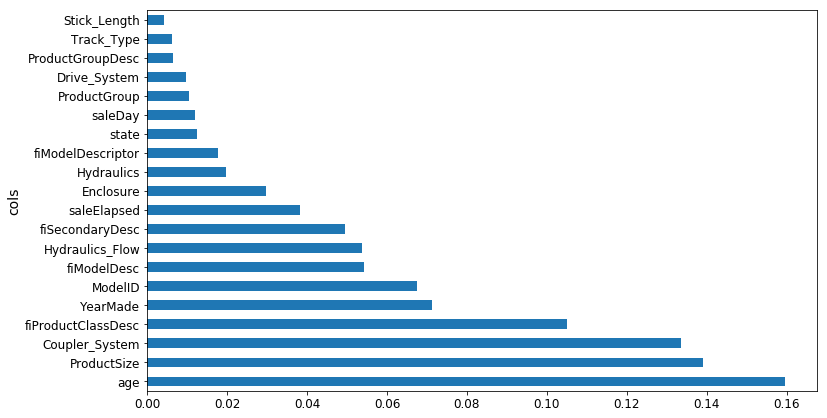

In [0]:
plot_fi(rf_feat_importance(m, X_train));

In [0]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [0]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
